<a href="https://colab.research.google.com/github/MAzarna1990/Momo/blob/main/Finding_relevant_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install tensorflow
!pip install -U pip setuptools wheel
!pip install pandas
!pip install wordcloud
!pip install nltk
!pip install textblob
!pip install threadpoolctl
!pip install -U imbalanced-learn
!pip install seaborn
!pip install keras
!python -m pip show tensorflow
!pip install tensorflow keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 51.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [39]:
!python -m spacy download en_core_web_sm
!python -m textblob.download_corpora

2023-10-15 18:29:37.526139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 58.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [124]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import string
import os
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from nltk import pos_tag
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, GRU, Activation, Dropout
from imblearn.over_sampling import SMOTE
from collections import Counter
from tqdm import tqdm
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from tensorflow import keras
from keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense
from keras.callbacks import EarlyStopping

In [125]:
df = '/content/Labeled.csv'
df = pd.read_csv(df)  # Assuming the CSV file is named 'ChatGPT_csv.csv'
df.head()


,Unnamed,Tweet,Tag
0,430734,Should I explore #ChatGPT + Python and create ...,irrelevant
1,345882,"4 Ways CHAT GPT Can Make You Money ($10,000/mo...",irrelevant
2,9558,ChatGPT Master: Ultimate OpenAI ChatGPT Course...,irrelevant
3,208302,I think I broke it. #ChatGPT https://t.co/rpkl...,irrelevant
4,166407,"In our latest blog, we went straight to the so...",irrelevant


In [126]:
df.shape

(19999, 3)

In [127]:
df.isnull().sum()

Unnamed    0
Tweet      0
Tag        0
dtype: int64

In [128]:
# Regular expression pattern to match URLs
url_pattern = r'https?://\S+|www\.\S+'

# Filter the DataFrame to keep rows with URLs
df_with_urls = df[df['Tweet'].str.contains(url_pattern, na=False)]

# Filter the DataFrame to keep rows without URLs
df_without_urls = df[~df['Tweet'].str.contains(url_pattern, na=False)]

# Save filtered DataFrames as CSV
df_with_urls.to_csv('tweets_with_urls.csv', index=False)
df_without_urls.to_csv('tweets_without_urls.csv', index=False)

print("Tweets with URLs saved as 'tweets_with_urls.csv'")
print("Tweets without URLs saved as 'tweets_without_urls.csv'")

Tweets with URLs saved as 'tweets_with_urls.csv'
Tweets without URLs saved as 'tweets_without_urls.csv'


In [129]:
# Filter the DataFrame to keep rows with URLs and labeled as "relevant"
df_relevant_with_urls = df_with_urls[df_with_urls['Tag'] == 'relevant']

# Save filtered DataFrame as CSV
df_relevant_with_urls.to_csv('relevant_tweets_with_urls.csv', index=False)


In [130]:
df_relevant_with_urls['Irrelevant'] = np.where(df_relevant_with_urls.Tag == 'Irrelevant', 1, 0)
df_relevant_with_urls.groupby(['Irrelevant', 'Tag']).size()

<ipython-input-130-747a9880b2a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant_with_urls['Irrelevant'] = np.where(df_relevant_with_urls.Tag == 'Irrelevant', 1, 0)


Irrelevant  Tag     
0           relevant    32
dtype: int64

In [131]:
df_without_urls['Irrelevant'] = np.where(df_without_urls.Tag == 'Irrelevant', 1, 0)
df_without_urls.groupby(['Irrelevant', 'Tag']).size()

<ipython-input-131-c4609d06099c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_urls['Irrelevant'] = np.where(df_without_urls.Tag == 'Irrelevant', 1, 0)


Irrelevant  Tag       
0           irrelevant    5326
            relevant      1352
dtype: int64

In [207]:
df = pd.concat([df_without_urls], ignore_index=True)

In [208]:
df.shape

(6678, 4)

In [209]:
df['Irrelevant'] = np.where(df.Tag == 'Irrelevant', 1, 0)
df.groupby(['Irrelevant', 'Tag']).size()

Irrelevant  Tag       
0           irrelevant    5326
            relevant      1352
dtype: int64

In [51]:
#df_NaN = df.fillna('NaN')
#df.fillna('NaN').head(2)

#df_NaN.isnull().sum()
#df = df_NaN


In [30]:
# Filter the relevant and irrelevant tweets based on the 'Tag' column
relevant_tweets = df1[df1['Tag'] == "relevant"]
irrelevant_tweets = df1[df1['Tag'] == "irrelevant"]

# Ensure you have the required number of relevant tweets
if len(relevant_tweets) != 1384:
    print(f"Warning: Expected 1384 relevant tweets but found {len(relevant_tweets)}.")

# Randomly select 2616 irrelevant tweets with replacement
random_irrelevant_tweets = irrelevant_tweets.sample(n=8616, replace=True, random_state=20)

# Concatenate the relevant and sampled irrelevant tweets into a single DataFrame
selected_tweets = pd.concat([relevant_tweets, random_irrelevant_tweets])

# Shuffle the selected_tweets DataFrame
selected_tweets = selected_tweets.sample(frac=1, random_state=42)

# Save the shuffled selected_tweets as a CSV file
selected_tweets.to_csv('shuffled_selected_tweets2.csv', index=False)

df = '/content/shuffled_selected_tweets2.csv'
df = pd.read_csv(df)  # Assuming the CSV file is named 'ChatGPT_csv.csv'

df['Irrelevant'] = np.where(df.Tag == 'Irrelevant', 1, 0)

df.groupby(['Irrelevant', 'Tag']).size()

df.head()

NameError: ignored

In [210]:
import re

def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweeted people'''
    if isinstance(tweet, str):
        return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
    else:
        return []

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    if isinstance(tweet, str):
        return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
    else:
        return []

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    if isinstance(tweet, str):
        return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
    else:
        return []

# Make new columns for retweeted usernames, mentioned usernames, and hashtags
df['retweeted'] = df['Tweet'].apply(find_retweeted)
df['mentioned'] = df['Tweet'].apply(find_mentioned)
df['hashtags'] = df['Tweet'].apply(find_hashtags)

In [211]:
# Take the rows from the hashtags column where there are actually hashtags
hashtags_list_df = df.loc[df.hashtags.apply(lambda hashtags_list: hashtags_list != []), ['hashtags']]
hashtags_list_df.head()

,hashtags
0,"[#ChatGPT, #builtdifferent]"
1,[#ChatGPT]
2,[#ChatGPT]
3,"[#ChatGPT, #OpenAI]"
4,"[#ChatGPT, #AI, #contentcreation]"


In [212]:
# Create dataframe where each one of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame([hashtag for hashtags_list in hashtags_list_df.hashtags for hashtag in hashtags_list],
                                    columns=['hashtag'])
flattened_hashtags_df.head()

,hashtag
0,#ChatGPT
1,#builtdifferent
2,#ChatGPT
3,#ChatGPT
4,#ChatGPT


In [213]:
#Number of unique hashtags
flattened_hashtags_df['hashtag'].unique().size

3655

# Preprocessing (Labeled data)

In [214]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# 1) Define contractions
contractions = {
   "ain't": "am not",
   "aren't": "are not",
   "can't": "cannot",
   "can't've": "cannot have",
   "'cause": "because",
   "could've": "could have",
   "couldn't": "could not",
   "couldn't've": "could not have",
   "didn't": "did not",
   "doesn't": "does not",
   "don't": "do not",
   "hadn't": "had not",
   "hadn't've": "had not have",
   "hasn't": "has not",
   "haven't": "have not",
   "he'd": "he would",
   "he'd've": "he would have",
   "he'll": "he will",
   "he'll've": "he will have",
   "he's": "he is",
   "how'd": "how did",
   "how'd'y": "how do you",
   "how'll": "how will",
   "how's": "how does",
   "i'd": "i would",
   "i'd've": "i would have",
   "i'll": "i will",
   "i'll've": "i will have",
   "i'm": "i am",
   "i've": "i have",
   "isn't": "is not",
   "it'd": "it would",
   "it'd've": "it would have",
   "it'll": "it will",
   "it'll've": "it will have",
   "it's": "it is",
   "let's": "let us",
   "ma'am": "madam",
   "mayn't": "may not",
   "might've": "might have",
   "mightn't": "might not",
   "mightn't've": "might not have",
   "must've": "must have",
   "mustn't": "must not",
   "mustn't've": "must not have",
   "needn't": "need not",
   "needn't've": "need not have",
   "o'clock": "of the clock",
   "oughtn't": "ought not",
   "oughtn't've": "ought not have",
   "shan't": "shall not",
   "sha'n't": "shall not",
   "shan't've": "shall not have",
   "she'd": "she would",
   "she'd've": "she would have",
   "she'll": "she will",
   "she'll've": "she will have",
   "she's": "she is",
   "should've": "should have",
   "shouldn't": "should not",
   "shouldn't've": "should not have",
   "so've": "so have",
   "so's": "so is",
   "that'd": "that would",
   "that'd've": "that would have",
   "that's": "that is",
   "there'd": "there would",
   "there'd've": "there would have",
   "there's": "there is",
   "they'd": "they would",
   "they'd've": "they would have",
   "they'll": "they will",
   "they'll've": "they will have",
   "they're": "they are",
   "they've": "they have",
   "to've": "to have",
   "wasn't": "was not",
   " u ": " you ",
   " ur ": " your ",
   " n ": " and ",
   "won't": "would not",
   'dis': 'this',
   'bak': 'back',
   'brng': 'bring'
}

# Function to expand contractions
def expand_contractions(text):
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    return text

# Apply preprocessing to the 'Tweet' column
df['Text_Contraction'] = df['Tweet'].apply(expand_contractions)


# 2) Stopwords
nltk.download('stopwords')

# Get the stopwords for a specific language (e.g., English)
stopwords_list = set(stopwords.words('english'))

# Define your custom list of stopwords
custom_stopwords = set(["a", "about", "above", "after", "again", "against", "ain't", "all", "am", "an",
    "and", "any", "are", "aren't", "as", "at", "be", "because", "been", "before",
    "being", "below", "between", "both", "but", "by", "can't", "cannot", "could",
    "couldn't", "did", "didn't", "do", "does", "doesn't", "doing", "don't", "down",
    "during", "each", "few", "for", "from", "further", "had", "hadn't", "has", "hasn't",
    "have", "haven't", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's",
    "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm",
    "i've", "if", "in", "into", "is", "isn't", "it", "it's", "its", "itself", "let's",
    "me", "more", "most", "mustn't", "my", "myself", "no", "nor", "not", "of", "off",
    "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out",
    "over", "own", "same", "shan't", "she", "she'd", "she'll", "she's", "should",
    "shouldn't", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs",
    "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll",
    "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
    "very", "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were", "weren't",
    "what", "what's", "when", "when's", "where", "where's", "which", "while", "who",
    "who's", "whom", "why", "why's", "with", "won't", "would", "wouldn't", "you", "you'd",
    "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves",
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
    "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
    'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
    'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
    'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
    'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having',
    'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
    'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about',
    'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above',
    'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
    'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some',
    'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
    's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd',
    'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn',
    "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
    "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn',
    "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
])

# Function to remove stopwords from a text
def remove_stopwords(text):
    if isinstance(text, str):
        # Tokenize the text
        words = text.split()
        # Filter out stopwords
        filtered_words = [word for word in words if word.lower() not in stopwords_list and word.lower() not in custom_stopwords]
        return ' '.join(filtered_words)
    else:
        return text  # Return non-string values as they are

# Apply the remove_stopwords function to the 'Tweet' column
df['tweet_stopwords'] = df['Text_Contraction'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [215]:
# 3) Function for removing noise
def clean_text(text):
    if isinstance(text, str):
        # Convert text to lowercase
        text = text.lower()
        # Combine multiple spaces into one
        text = ' '.join(text.split())
        # Remove Twitter usernames and URLs
        text = re.sub(r'(@\w+)|(http\S+)', '', text)
        # Remove non-alphabet characters and numbers
        text = re.sub(r'[^a-zA-Z ]', ' ', text)
        # Remove words with less than 3 characters (usually stopwords)
        text = re.sub(r'\b\w{1,2}\b', '', text)
    else:
        text = ''  # Convert non-string values to an empty string
    return text

# Apply preprocessing to the 'Tweet' column
df['text_cleaning'] = df['tweet_stopwords'].apply(clean_text)

In [216]:
# 4) Lemmatization

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df["text_final"] = df["text_cleaning"].apply(lambda text: lemmatize_words(text))
df.head()

,Unnamed,Tweet,Tag,Irrelevant,retweeted,mentioned,hashtags,Text_Contraction,tweet_stopwords,text_cleaning,text_final
0,430734,Should I explore #ChatGPT + Python and create ...,irrelevant,0,[],[],"[#ChatGPT, #builtdifferent]",Should I explore #ChatGPT + Python and create ...,explore #ChatGPT + Python create accounts blow...,explore chatgpt python create accounts blow...,explore chatgpt python create account blow pas...
1,4172,What are the 30 best mafia movies to watch to ...,irrelevant,0,[],[],[#ChatGPT],What are the 30 best mafia movies to watch to ...,30 best mafia movies watch fully understand ma...,best mafia movies watch fully understand ma...,best mafia movie watch fully understand mafia ...
2,120117,I put a bot with #ChatGPT integration on a tes...,irrelevant,0,[],[],[#ChatGPT],I put a bot with #ChatGPT integration on a tes...,put bot #ChatGPT integration test site. option...,put bot chatgpt integration test site option...,put bot chatgpt integration test site option e...
3,451334,Is it possible to create an AI avatar of a per...,irrelevant,0,[],[],"[#ChatGPT, #OpenAI]",Is it possible to create an AI avatar of a per...,possible create AI avatar person? (train AI us...,possible create avatar person train using ...,possible create avatar person train use text v...
4,220309,AI is neither artificial nor intelligent. Chat...,relevant,0,[],[],"[#ChatGPT, #AI, #contentcreation]",AI is neither artificial nor intelligent. Chat...,AI neither artificial intelligent. ChatGPT tra...,neither artificial intelligent chatgpt train...,neither artificial intelligent chatgpt train v...


### **Labels**

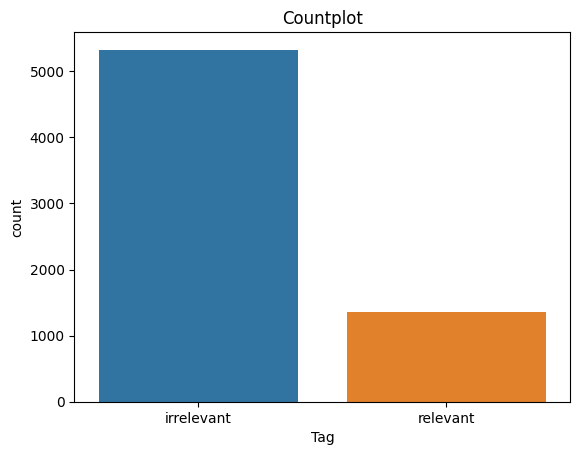

In [217]:
# Assuming df is your DataFrame with a 'Tag' column
sns.countplot(data=df, x='Tag')
plt.xlabel("Tag")
plt.title("Countplot")
plt.show()

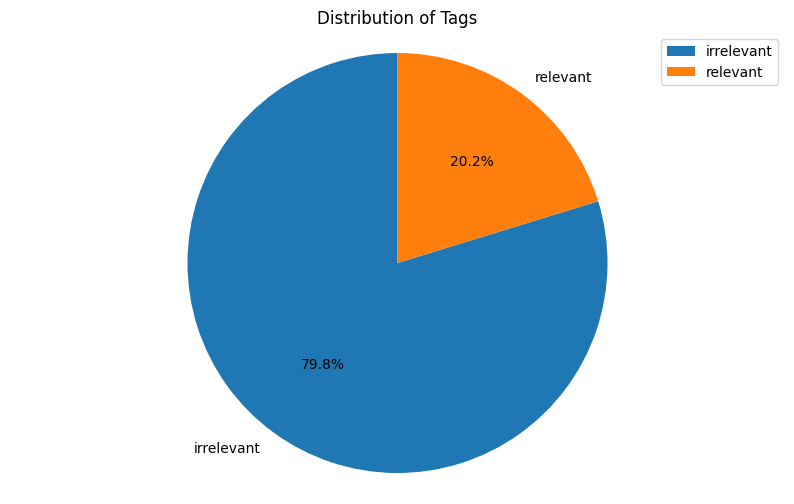

In [218]:
#Pir chart for Irrelative and relative percentage

# Sample data (replace with your own)
labels = df['Tag'].value_counts().index
sizes = df['Tag'].value_counts().values

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%.1f%%', startangle=90)
plt.title('Distribution of Tags')
plt.legend(loc='upper right', labels=labels)
plt.axis('equal')

plt.show()

In [219]:
df['Irrelevant'] = np.where(df.Tag == 'Irrelevant', 1, 0)

In [220]:
df.groupby(['Irrelevant', 'Tag']).size()

Irrelevant  Tag       
0           irrelevant    5326
            relevant      1352
dtype: int64

### TF-IDF, Encoding, and Splitting

In [221]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE  # Importing SMOTE

# ...[Your dataset loading and other preprocessing]

# 6) Split the dataset and preprocess
X = df['text_final']
y = df['Tag']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=25)

encoder = LabelEncoder()
encoder.fit(y_train)

train_y = encoder.transform(y_train)
val_y = encoder.transform(y_val[y_val.isin(encoder.classes_)])
test_y = encoder.transform(y_test[y_test.isin(encoder.classes_)])

# Initialize TfidfVectorizer with ngram_range
Tfidf_vec = TfidfVectorizer(ngram_range=(1, 2))
Tfidf_vec.fit(X_train)

Train_X_Tfidf = Tfidf_vec.transform(X_train)
Val_X_Tfidf = Tfidf_vec.transform(X_val)
Test_X_Tfidf = Tfidf_vec.transform(X_test)

# 7) Handling class imbalance with SMOTE
smote = SMOTE(random_state=25)
Train_X_Tfidf_resampled, train_y_resampled = smote.fit_resample(Train_X_Tfidf, train_y)


# **Classification Techniques**

**Support Vector Machine (SVM)**

In [222]:
# Imports
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning

# Define the parameter grid for GridSearchCV
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'dual': [False]  # l1 penalty with 'LinearSVC' requires dual=False
}

# Initialize Grid Search with verbosity for logging progress
# n_jobs=-1 will utilize all available CPUs for faster computation
grid_search = GridSearchCV(
    LinearSVC(class_weight='balanced'),  # Add class_weight='balanced' here
    param_grid,
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to the data
# Handling potential convergence warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    grid_search.fit(Train_X_Tfidf_resampled, train_y_resampled)

# Display best parameters found by the grid search
print("Best Parameters (Grid Search):", grid_search.best_params_)

# Predict decision function values (distances to the hyperplane)
decision_values = grid_search.decision_function(Test_X_Tfidf)

# Apply threshold of 0
threshold = 0
linear_predictions = (decision_values > threshold).astype(int)

# Evaluate predictions
linear_accuracy = accuracy_score(test_y, linear_predictions)
linear_confusion_matrix = confusion_matrix(test_y, linear_predictions)
linear_classification_report = classification_report(test_y, linear_predictions)

print('Test accuracy with the best linear SVM is', linear_accuracy * 100)
print('Confusion matrix for linear SVM:')
print(linear_confusion_matrix)
print('Classification report for linear SVM:')
print(linear_classification_report)

# Cross-validation with the best estimator
cross_val_scores = cross_val_score(grid_search.best_estimator_, Train_X_Tfidf_resampled, train_y_resampled, cv=5)
print("Cross-validation scores with the best estimator:", cross_val_scores)
print("Average CV accuracy:", cross_val_scores.mean())


Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best Parameters (Grid Search): {'C': 10, 'dual': False, 'penalty': 'l2'}
Test accuracy with the best linear SVM is 77.69461077844312
Confusion matrix for linear SVM:
[[480  60]
 [ 89  39]]
Classification report for linear SVM:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       540
           1       0.39      0.30      0.34       128

    accuracy                           0.78       668
   macro avg       0.62      0.60      0.60       668
weighted avg       0.76      0.78      0.77       668

Cross-validation scores with the best estimator: [0.95828437 0.95652174 0.97121034 0.97413286 0.96825397]
Average CV accuracy: 0.9656806565019125


In [223]:
!pip install joblib

In [224]:
import joblib

# Save the model to a file
filename = 'grid_search_model.pkl'
joblib.dump(grid_search, filename)


['grid_search_model.pkl']

In [225]:
from joblib import load

# Load the model from the file
loaded_model = joblib.load(filename)


In [226]:
df2 = '/content/Unlabeled1.csv'
df2 = pd.read_csv(df2)  # Load your unlabeled dataset

In [227]:
df2.head()

,Unnamed: 0,Tweet
0,0,#ChatGPT If only there were a movie or somethi...
1,1,"Workshop Description: In this workshop, you wi..."
2,2,New Post at AiNewsDrop!\n\nChatGPT is a doctor...
3,3,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...
4,4,"""Classical art"" is struggling - not changed th..."


In [228]:
df2.shape

(458348, 2)

In [229]:
# Regular expression pattern to match URLs
url_pattern = r'https?://\S+|www\.\S+'

# Filter the DataFrame to keep rows with URLs
df_Unlabeled_with_urls = df2[df2['Tweet'].str.contains(url_pattern, na=False)]

# Filter the DataFrame to keep rows without URLs
df_Unlabeled_without_urls = df2[~df2['Tweet'].str.contains(url_pattern, na=False)]

# Save filtered DataFrames as CSV
df_Unlabeled_with_urls.to_csv('tweets_Unlabeled_with_urls.csv', index=False)
df_Unlabeled_without_urls.to_csv('tweets_Unlabeled_without_urls.csv', index=False)

print("Tweets with URLs saved as 'tweets_Unlabeled_with_urls.csv'")
print("Tweets without URLs saved as 'tweets_Unlabeled_without_urls.csv'")

Tweets with URLs saved as 'tweets_Unlabeled_with_urls.csv'
Tweets without URLs saved as 'tweets_Unlabeled_without_urls.csv'


In [230]:
df3 = '/content/tweets_Unlabeled_without_urls.csv'
df3 = pd.read_csv(df3)  # Load your unlabeled dataset

In [231]:
df3.shape

(153593, 2)

In [232]:
df3['Tweet'].fillna('', inplace=True)

In [233]:
df3.head()

,Unnamed: 0,Tweet
0,0,#ChatGPT If only there were a movie or somethi...
1,4,"""Classical art"" is struggling - not changed th..."
2,21,"well, #ChatGPT made me change my idea of not g..."
3,22,@AlisynCamerota \n\nTLDR is one of the best th...
4,23,#TaxTwitter I was able to use #ChatGPT to calc...


In [234]:
# Apply preprocessing steps to the 'Tweet' column
df3['Text_Contraction'] = df3['Tweet'].apply(expand_contractions)  # Apply contractions
df3['tweet_stopwords'] = df3['Text_Contraction'].apply(remove_stopwords)  # Remove stopwords
df3['text_cleaning'] = df3['tweet_stopwords'].apply(clean_text)  # Clean text
df3["text_final"] = df3["text_cleaning"].apply(lambda text: lemmatize_words(text))  # Lemmatization
df3.head()

,Unnamed: 0,Tweet,Text_Contraction,tweet_stopwords,text_cleaning,text_final
0,0,#ChatGPT If only there were a movie or somethi...,#ChatGPT If only there were a movie or somethi...,#ChatGPT movie something showed us ends.,chatgpt movie something showed ends,chatgpt movie something show end
1,4,"""Classical art"" is struggling - not changed th...","""Classical art"" is struggling - not changed th...","""Classical art"" struggling - changed fact this...",classical art struggling changed fact this...,classical art struggle change fact thisappeari...
2,21,"well, #ChatGPT made me change my idea of not g...","well, #ChatGPT made me change my idea of not g...","well, #ChatGPT made change idea giving titles ...",well chatgpt made change idea giving titles ...,well chatgpt make change idea give title amp d...
3,22,@AlisynCamerota \n\nTLDR is one of the best th...,@AlisynCamerota \n\nTLDR is one of the best th...,@AlisynCamerota TLDR one best things #ChatGPT ...,tldr one best things chatgpt does type tldr...,tldr one best thing chatgpt do type tldr give ...
4,23,#TaxTwitter I was able to use #ChatGPT to calc...,#TaxTwitter I was able to use #ChatGPT to calc...,#TaxTwitter able use #ChatGPT calculate total ...,taxtwitter able use chatgpt calculate total ...,taxtwitter able use chatgpt calculate total pr...


In [235]:
# Vectorize the unlabeled data using the same vectorizer as the labeled data
Unlabeled_X_Tfidf = Tfidf_vec.transform(df3['text_final'])

In [236]:
unlabeled_predictions = loaded_model.predict(Unlabeled_X_Tfidf)

In [237]:
# Assuming you have 'unlabeled_predictions' as a NumPy array or a list
#Create a DataFrame to pair predictions with data
predictions_df = pd.DataFrame({'Tweet': df3['Tweet'], 'Predicted_Labels': unlabeled_predictions})

In [238]:
# Save the DataFrame to a CSV file
predictions_df.to_csv('unlabeled_predictions.csv', index=False)

In [239]:
df4 = pd.read_csv('unlabeled_predictions.csv')  # Assuming the CSV file is named 'ChatGPT_csv.csv'
df4.head()

,Tweet,Predicted_Labels
0,#ChatGPT If only there were a movie or somethi...,0
1,"""Classical art"" is struggling - not changed th...",0
2,"well, #ChatGPT made me change my idea of not g...",1
3,@AlisynCamerota \n\nTLDR is one of the best th...,0
4,#TaxTwitter I was able to use #ChatGPT to calc...,0


In [240]:
df4.shape

(153593, 2)

In [241]:
def label_to_meaning(label):
    if label == 0:
        return "irrelevant"
    elif label == 1:
        return "relevant"
    else:
        return "unknown"  # Add handling for other labels if needed

def meaning_to_label(meaning):
    if meaning == "irrelevant":
        return 0
    elif meaning == "relevant":
        return 1
    else:
        return -1  # Return a default value for unknown meanings

# Example usage:
label = 0
meaning = label_to_meaning(label)
print(f"{label} represents {meaning}")

meaning = "relevant"
label = meaning_to_label(meaning)
print(f"{meaning} represents {label}")

# Assuming you've already loaded a dataframe named df1, you can print its columns:
#print(df1.columns)

import pandas as pd

# Assuming you have a DataFrame called 'df1' with a 'Predicted_Labels' column
# Example DataFrame structure for demonstration:
# df1 = pd.DataFrame({'Predicted_Labels': [0, 1, 0, 1, 1, 0, 0, 1, 0, 1]})

# Count the number of zeros (0s) in the 'Predicted_Labels' column
count_zero = (df4['Predicted_Labels'] == 0).sum()
count_one = (df4['Predicted_Labels'] == 1).sum()

# Print the count
print(f"Number of zeros in the 'Predicted_Labels' column: {count_zero}")
print(f"Number of ones in the 'Predicted_Labels' column: {count_one}")


0 represents irrelevant
relevant represents 1
Number of zeros in the 'Predicted_Labels' column: 125480
Number of ones in the 'Predicted_Labels' column: 28113


In [242]:
# Define a mapping dictionary for label conversion
label_mapping = {0: 'irrelevant', 1: 'relevant'}

# Apply the mapping to the 'Label' column
df4['Predicted_Labels'] = df4['Predicted_Labels'].map(label_mapping)

# Print the updated DataFrame
print(df4)


                                                    Tweet Predicted_Labels
0       #ChatGPT If only there were a movie or somethi...       irrelevant
1       "Classical art" is struggling - not changed th...       irrelevant
2       well, #ChatGPT made me change my idea of not g...         relevant
3       @AlisynCamerota \n\nTLDR is one of the best th...       irrelevant
4       #TaxTwitter I was able to use #ChatGPT to calc...       irrelevant
...                                                   ...              ...
153588  Generated from asking #ChatGPT to tell me joke...       irrelevant
153589  Why couldn't the shrimp share his toys? Becaus...       irrelevant
153590        and that we are a part of. \n#ChatGPT @sama       irrelevant
153591  I asked #ChatGPT from @OpenAI about some nerdy...       irrelevant
153592  Ok #ChatGPT go into 'gaga' mode ... when I sta...       irrelevant

[153593 rows x 2 columns]


In [243]:
# Save the DataFrame as a CSV file
df4.to_csv('converted_labels1.csv', index=False)

print("DataFrame with converted labels saved as 'converted_labels.csv'")

DataFrame with converted labels saved as 'converted_labels.csv'


In [244]:
df5 = '/content/converted_labels1.csv'
df5 = pd.read_csv(df5)  # Assuming the CSV file is named 'ChatGPT_csv.csv'


In [245]:
df5.head()

,Tweet,Predicted_Labels
0,#ChatGPT If only there were a movie or somethi...,irrelevant
1,"""Classical art"" is struggling - not changed th...",irrelevant
2,"well, #ChatGPT made me change my idea of not g...",relevant
3,@AlisynCamerota \n\nTLDR is one of the best th...,irrelevant
4,#TaxTwitter I was able to use #ChatGPT to calc...,irrelevant


In [246]:
df5['Irrelevant'] = np.where(df5.Predicted_Labels == 'Irrelevant', 1, 0)
df5.groupby(['Irrelevant', 'Predicted_Labels']).size()

Irrelevant  Predicted_Labels
0           irrelevant          125480
            relevant             28113
dtype: int64

In [247]:
# Split the DataFrame into two separate DataFrames based on the 'Label' column
df_irrelevant = df5[df5['Predicted_Labels'] == 'irrelevant']
df_relevant = df5[df5['Predicted_Labels'] == 'relevant']

# Save the two DataFrames as CSV files
df_irrelevant.to_csv('irrelevant_tweets.csv', index=False)
df_relevant.to_csv('relevant_tweets3.csv', index=False)

print("Irrelevant tweets saved as 'irrelevant_tweets.csv'")
print("Relevant tweets saved as 'relevant_tweets3.csv'")

Irrelevant tweets saved as 'irrelevant_tweets.csv'
Relevant tweets saved as 'relevant_tweets3.csv'


In [248]:
# Split the DataFrame into two separate DataFrames based on the 'Predicted_Labels' column
df_irrelevant = df[df['Tag'] == 'irrelevant']
df_relevant = df[df['Tag'] == 'relevant']

# Save the 'final_text' column of the relevant tweets as a CSV file
df_relevant[['Tweet']].to_csv('relevant_tweets33333.csv', index=False)


In [249]:
df6 = '/content/relevant_tweets3.csv'
df6 = pd.read_csv(df6)  # Assuming the CSV file is named 'ChatGPT_csv.csv'


In [250]:
df7 = '/content/relevant_tweets33333.csv'
df7 = pd.read_csv(df7)  # Assuming the CSV file is named 'ChatGPT_csv.csv'


In [251]:
# Combine the two DataFrames vertically (stack them)
final_df = pd.concat([df6, df7], ignore_index=True)

# Save the combined DataFrame as a CSV file
final_df.to_csv('combined_data.csv', index=False)

print("Combined data saved as 'combined_data.csv'")

Combined data saved as 'combined_data.csv'


In [252]:
df_final = '/content/combined_data.csv'
df_final = pd.read_csv(df_final)  # Assuming the CSV file is named 'ChatGPT_csv.csv'


In [253]:
df_final.head()

,Tweet,Predicted_Labels,Irrelevant
0,"well, #ChatGPT made me change my idea of not g...",relevant,0.0
1,Man… every now and then #chatgpt will sureAF p...,relevant,0.0
2,why aren't #ChatGPT integrated into phone appl...,relevant,0.0
3,I love chatgpt but I’m dumber now if that’s ev...,relevant,0.0
4,I just asked #ChatGPT to write a tax Valentine...,relevant,0.0


In [254]:
df_final.shape

(29465, 3)